In [335]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import seaborn as sns
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

import warnings
from time import time
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras import backend as kb
from keras import initializers, regularizers, constraints
from keras import activations as ka
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dot

from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras import metrics

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as sm

In [336]:
dataBlocks = []
# for num in range(1,112):
#     df = pd.read_csv("dane/halfhourly_dataset/block_"+str(num)+".csv")
#     dataBlocks.append(df)

#data = pd.concat(dataBlocks, ignore_index=True)

df = pd.read_csv("dane/halfhourly_dataset/block_0.csv")

data = df.loc[df["LCLid"] == "MAC000002"]

In [337]:
data['date_time'] = pd.to_datetime(data['tstp'])
data = data.dropna(subset=['energy(kWh/hh)'])
data = data[['LCLid', 'date_time', 'energy(kWh/hh)']]

C:\Users\Konrad\AppData\Local\Temp\ipykernel_208\1794836604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_time'] = pd.to_datetime(data['tstp'])


In [338]:
data['year'] = data['date_time'].apply(lambda x: x.year)
data['quarter'] = data['date_time'].apply(lambda x: x.quarter)
data['month'] = data['date_time'].apply(lambda x: x.month)
data['day'] = data['date_time'].apply(lambda x: x.day)
data['hour'] = data['date_time'].apply(lambda x: x.hour)
data['minute'] = data['date_time'].apply(lambda x: x.minute)

In [339]:
data = data.loc[:,['date_time','energy(kWh/hh)', 'year', 'quarter', 'month', 'day', 'hour', 'minute']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data['weekday'] = data['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

In [340]:
data.head()

,date_time,energy(kWh/hh),year,quarter,month,day,hour,minute,weekday
0,2012-10-12 00:30:00,0,2012,4,10,12,0,30,1
1,2012-10-12 01:00:00,0,2012,4,10,12,1,0,1
2,2012-10-12 01:30:00,0,2012,4,10,12,1,30,1
3,2012-10-12 02:00:00,0,2012,4,10,12,2,0,1
4,2012-10-12 02:30:00,0,2012,4,10,12,2,30,1


In [341]:
data.tail()

,date_time,energy(kWh/hh),year,quarter,month,day,hour,minute,weekday
24136,2014-02-27 22:00:00,0.416,2014,1,2,27,22,0,1
24137,2014-02-27 22:30:00,1.35,2014,1,2,27,22,30,1
24138,2014-02-27 23:00:00,1.247,2014,1,2,27,23,0,1
24139,2014-02-27 23:30:00,1.2180001,2014,1,2,27,23,30,1
24140,2014-02-28 00:00:00,1.387,2014,1,2,28,0,0,1


In [342]:
print('Liczba wierszy i kolumn:', data.shape)
print('Najstarsza data:', data.date_time.min())
print('Najnowsza data:', data.date_time.max())

Liczba wierszy i kolumn: (24141, 9)
Najstarsza data: 2012-10-12 00:30:00
Najnowsza data: 2014-02-28 00:00:00


In [343]:
data = data.loc[data["energy(kWh/hh)"] != "Null"]

In [344]:
# energyPerDay = data.groupby('date_time')[['energy_sum']].sum()
# data.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
# energyPerDay.reset_index()
# data = data.merge(energyPerDay, on='date_time', how='left')
# data.drop(['energy_sum_x'], inplace=True, axis=1)
# data.rename(columns={'energy_sum_y':'energy_sum'}, inplace=True)

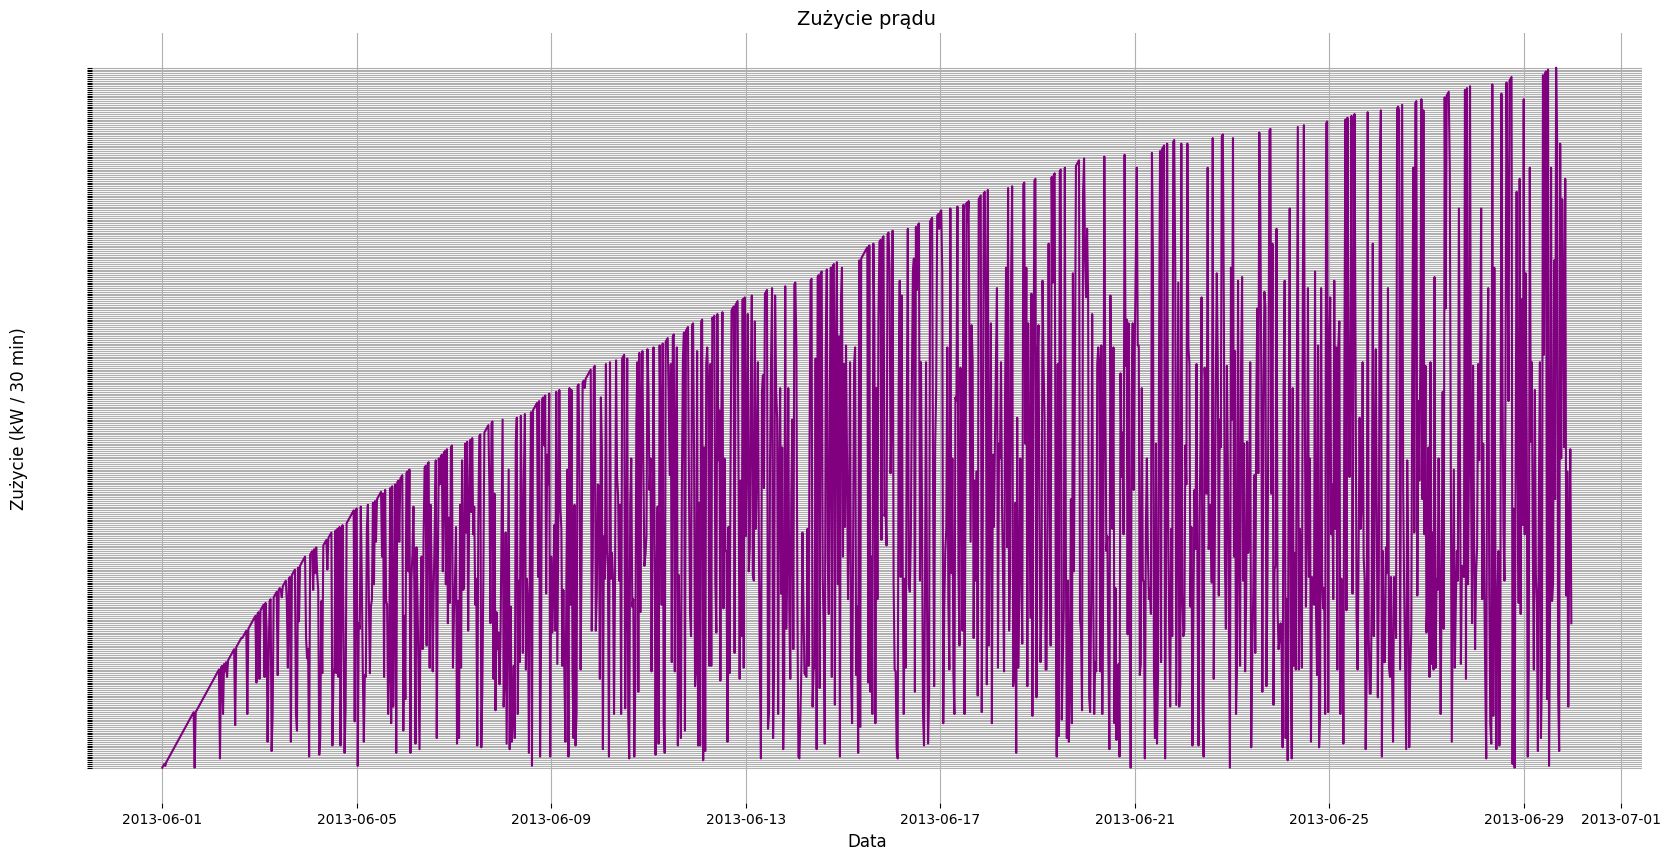

In [345]:
data1 = data[(data.date_time >= '2013-06-01') & (data.date_time < '2013-06-30')]
plt.figure(figsize=(20,10))
plt.plot(data1.date_time, data1["energy(kWh/hh)"], color='purple')
plt.ylabel('Zużycie (kW / 30 min)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.title('Zużycie prądu', fontsize=14)
plt.grid(True)
plt.yticks(color='w') #ENGINEER
sns.despine(bottom=True, left=True)
plt.show()

In [346]:
dataset = data["energy(kWh/hh)"].values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) - 480)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [347]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [348]:
X_train, Y_train = create_dataset(train, 30)
X_test, Y_test = create_dataset(test, 30)
print(X_train.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(23629, 30)
(449, 30)
(23629, 1, 30)
(449, 1, 30)


In [349]:
class Attention(Layer):

    def __init__(self, units=32, return_sequences=True, **kwargs):

        self.units = units

        self.return_sequences = return_sequences

        super(Attention, self).__init__(**kwargs)

 

    def build(self, input_shape):

        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], self.units),

                                 initializer="normal")

        self.b = self.add_weight(name="att_bias", shape=(self.units,),

                                 initializer="zeros")

        self.u = self.add_weight(name="att_context", shape=(self.units, 1),

                                 initializer="normal")

        super(Attention, self).build(input_shape)

 

    def call(self, x):
        u = ka.tanh(tf.keras.backend.dot(x, self.W) + self.b) # sprawdzic inna funckje
        #v = ka.relu(tf.keras.backend.dot(x, self.W) + self.b)

        #scores = tf.keras.backend.dot(tf.keras.backend.dot(u, v), self.u)
        scores = tf.keras.backend.dot(u, self.u)
        weights = ka.softmax(scores, axis=1)
        weighted_input = x * weights

        if self.return_sequences:
            return weighted_input

        else:
            return tf.keras.backend.sum(weighted_input, axis=1)

 

    def compute_output_shape(self, input_shape):

        if self.return_sequences:

            return input_shape

        else:

            return (input_shape[0], input_shape[-1])

    def get_config(self):

        config = {'attention_dim': self.attention_dim}

        base_config = super(Attention, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [357]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(units=50, return_sequences=True)(input_layer)
attention_layer = Attention(50)(lstm_layer)
lstm_att_layer = LSTM(units=100, return_sequences=True)(attention_layer)
attention_layer_2 = Attention(50)(lstm_att_layer)
lstm_att_layer_2 = LSTM(units=100, return_sequences=True)(attention_layer_2)
attention_layer_3 = Attention(50)(lstm_att_layer_2)
lstm_att_layer_3 = LSTM(units=100, return_sequences=True)(attention_layer_3)
attention_layer_4 = Attention(50)(lstm_att_layer_3)
lstm_att_layer_4 = LSTM(units=100)(attention_layer_4)
dropout_layer = Dropout(0.2)(lstm_att_layer_4)
output_layer = Dense(units = 1, activation='sigmoid', kernel_constraint=MaxNorm(3))(dropout_layer)

model = keras.Model(input_layer, output_layer)

# model.add(input_layer)
# model.add(lstm_layer)
# model.add(attention_layer)
# model.add(lstm_att_layer)
# # model.add(LSTM(units=50, return_sequences=True))
# # model.add(Dropout(0.2))
# # model.add(LSTM(units=100, return_sequences=True))
# # model.add(LSTM(units=100, return_sequences=True))
# # model.add(Dropout(0.2))
# # model.add(LSTM(units=100, return_sequences=True))
# # model.add(LSTM(units=100, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=1, activation='sigmoid', kernel_constraint=MaxNorm(3)))

#sgd = SGD(learning_rate=0.2, momentum=0.9)
# #model.compile(loss='mae', optimizer='rmsprop')
# #model.compile(loss='mean_squared_error', optimizer='rmsprop')
# #model.compile(loss=tf.keras.losses.MeanSquaredError(reduction="none"), optimizer='adam')
model.compile(loss='mae', optimizer='adam')


history = model.fit(X_train, Y_train, epochs=100, batch_size=96, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

Epoch 1/100


OperatorNotAllowedInGraphError: Exception encountered when calling ScaledDotProductAttention.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by ScaledDotProductAttention.call():
  • inputs=tf.Tensor(shape=(None, 1, 50), dtype=float32)

In [ ]:
model.summary()

Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 1, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 1, 50)          │        16,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_5 (Attention)         │ (None, 1, 50)          │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 1, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1, 1)           │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,035 (445.45 KB)

 Trainable params: 38,011 (148.48 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,024 (296.97 KB)

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Średni błąd bezwzględny na zbiorze testowym:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym: ',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Średni błąd bezwzględny na zbiorze treningowym:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

 57/739 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step  

c:\Users\Konrad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


ValueError: Found array with dim 3. None expected <= 2.

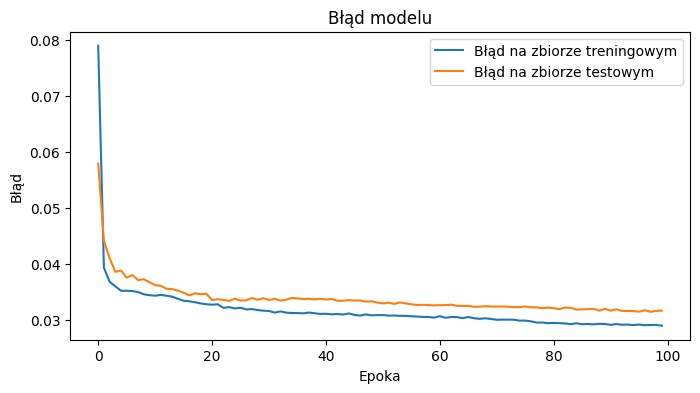

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Błąd na zbiorze treningowym')
plt.plot(history.history['val_loss'], label='Błąd na zbiorze testowym')
plt.title('Błąd modelu')
plt.ylabel('Błąd')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()

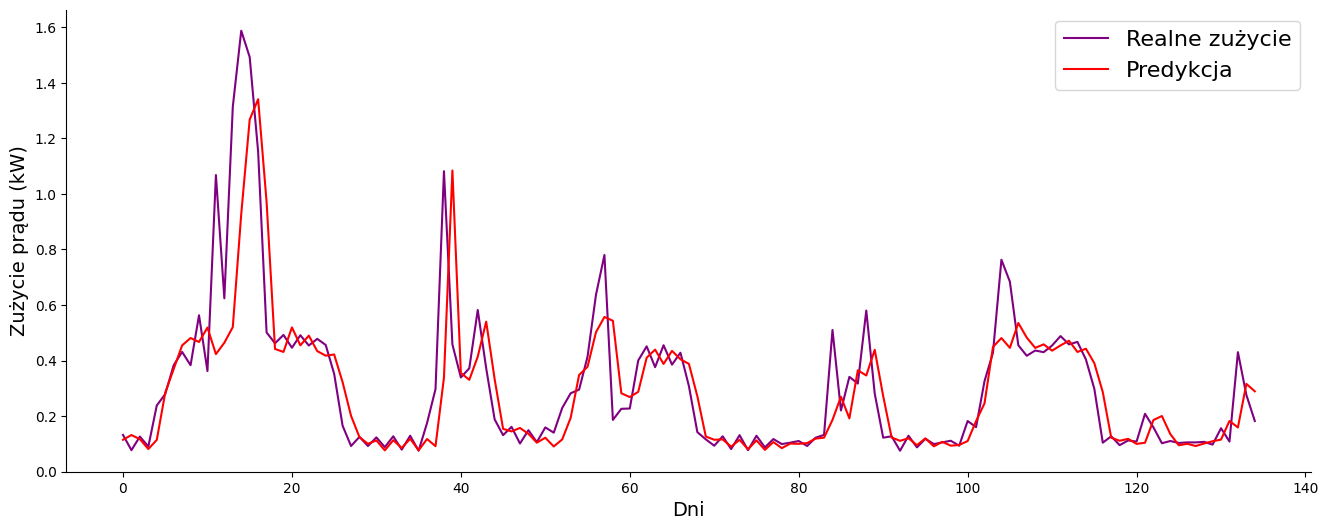

In [ ]:
aa=[x for x in range(135)]
                    
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:135], label="Realne zużycie", color='purple')
plt.plot(aa, test_predict[:,0][:135], label="Predykcja", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Zużycie prądu (kW)', size=14)
plt.xlabel('Dni', size=14)
plt.legend(fontsize=16)
plt.show()

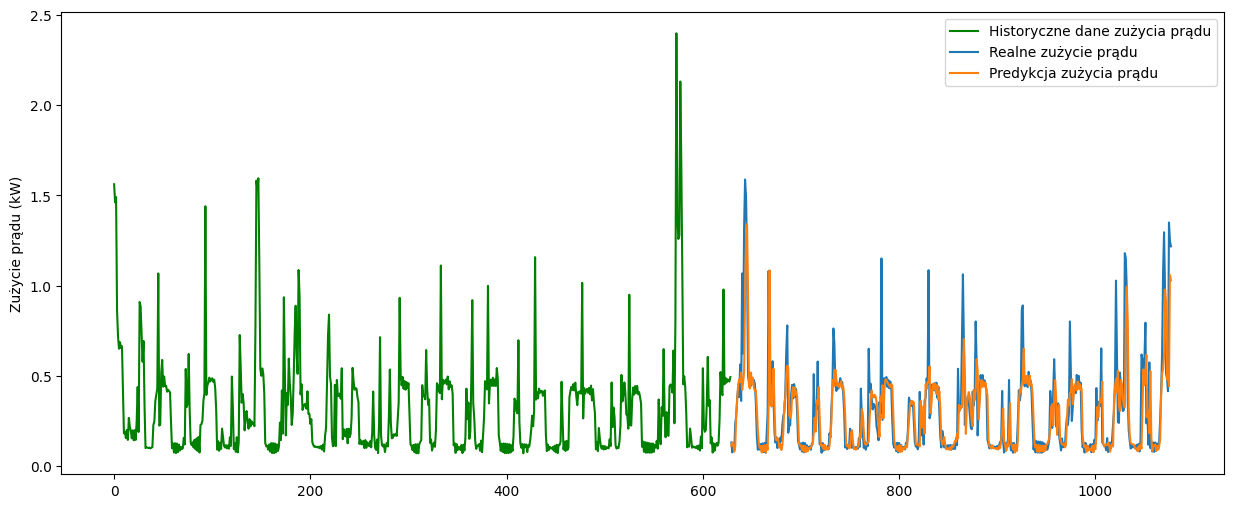

In [ ]:
aa=[x for x in range(30)]
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(Y_train[0][23000:23630])), Y_train[0][23000:23630], 'g', label="Historyczne dane zużycia prądu")
plt.plot(np.arange(len(Y_train[0][23000:23630]), len(Y_train[0][23000:23630]) + len(Y_test[0])), Y_test[0], label="Realne zużycie prądu")
plt.plot(np.arange(len(Y_train[0][23000:23630]), len(Y_train[0][23000:23630]) + len(Y_test[0])), test_predict[:,0], label="Predykcja zużycia prądu")
plt.ylabel('Zużycie prądu (kW)')
plt.legend()
plt.show()